In [61]:
import pandas as pd
import osmnx as ox
import ast

# Load the nodes files
complete_nodes = pd.read_csv("nodes_complete.csv", sep=";")
incomplete_nodes = pd.read_csv("bologna_nodes_p.csv", sep=";")




# Load the edges files
complete_edges = pd.read_csv("edges_complete.csv", sep=";")
incomplete_edges = pd.read_csv("bologna_edges_p.csv", sep=";")


# Check if there are edges without nodes

# assert set(incomplete_edges["u_original"]).issubset(set(incomplete_nodes["osmid_original"]))
# assert set(incomplete_edges["v_original"]).issubset(set(incomplete_nodes["osmid_original"]))
# assert set(complete_edges["u_original"]).issubset(set(complete_nodes["osmid_original"]))
# assert set(complete_edges["v_original"]).issubset(set(complete_nodes["osmid_original"]))

# #   ERRORE   

# assert set(incomplete_edges["u_original"]).issubset(set(complete_nodes["osmid_original"]))
# assert set(incomplete_edges["v_original"]).issubset(set(complete_nodes["osmid_original"]))


# Define residential flags
FLAGS_RESIDENTIAL = [
    "residential",
    "living_street",
    "unclassified",
    "service",
    "pedestrian",
    "busway",
]

# Filter the complete edges for residential streets
residential_streets = complete_edges[complete_edges["highway"].isin(FLAGS_RESIDENTIAL)]
print(len(residential_streets))

# Extract all nodes (u and v) from the incomplete graph
incomplete_nodes_set = set(incomplete_nodes["osmid_original"])
print(len(incomplete_nodes_set))



# Find residential streets adjacent to the incomplete graph
# streets_to_add = []
# for _, row in residential_streets.iterrows():
#     u, v = row["u_original"], row["v_original"]
    
#     if u in incomplete_nodes_set or v in incomplete_nodes_set:
#         streets_to_add.append(row.to_dict())
        
# Handle nested lists in `incomplete_nodes_set`








    # for index, row in gdf_nodes.iterrows():
    # # if "osmid_original" is a list, keep the first element
    #     old_list = ast.literal_eval(str(row["osmid_original"]))
    #     if isinstance(old_list, list):
    #         new_id = old_list[0]
    #         # update the edges with u_original or v_original in old_list, with new_id
    #         gdf_edges.loc[gdf_edges["u_original"].isin(old_list), "u_original"] = new_id
    #         gdf_edges.loc[gdf_edges["v_original"].isin(old_list), "v_original"] = new_id
    #         # update the node with new_id
    #         gdf_nodes.loc[index, "osmid_original"] = new_id







listine=0
valorini=0

streets_to_add = []

for _, row in residential_streets.iterrows():
    u, v = row["u_original"], row["v_original"]
    found_match = False

    for index, row_nodes in complete_nodes.iterrows():
    # if "osmid_original" is a list, keep the first element
        old_list = ast.literal_eval(str(row_nodes["osmid_original"]))
        if isinstance(old_list, list):
            if (u in old_list) or (v in old_list):
                for index in incomplete_nodes_set:
                    if index in old_list:
                        found_match = True
                        if u in old_list:
                            row["u_original"] = index
                        if v in old_list:
                            row["u_original"] = index
                        listine += 1 
                        break 
        else:
            if u == old_list or v == old_list:
                for index in incomplete_nodes_set:
                    if u == index or v == index:
                        found_match = True
                        valorini += 1
                    



        #     # If the node is not a list, compare directly
        #     if u == old_list or v == old_list:
        #         found_match = True
        #         valorini += 1
        #         break
        if found_match:
            break

        
    if found_match:
        streets_to_add.append(row.to_dict())


    #if u in incomplete_nodes_set or v in incomplete_nodes_set:
    #    streets_to_add.append(row.to_dict())
    #    valorini += 1



print('liste=' , listine, 'valori=' , valorini)

#                                                  ---------------------------- E' QUI IL PROBLEMA --------------------------------


# Create a DataFrame for new edges and append it to the incomplete edges
new_streets = pd.DataFrame(streets_to_add)
print(new_streets)



updated_incomplete_edges = pd.concat([incomplete_edges, new_streets], ignore_index=True)
updated_incomplete_edges = updated_incomplete_edges.drop_duplicates(subset=["u_original", "v_original"])

# Extract all unique nodes used in the updated edges
# Convert columns to string and combine their sets
updated_nodes_set = (
    set(updated_incomplete_edges["u_original"].map(str))
    .union(updated_incomplete_edges["v_original"].map(str))
)


# Filter the complete nodes to include only those in the updated nodes set
# Filter the complete nodes to include only those in the updated nodes set
nodes_to_add = []
for index, row in complete_nodes.iterrows():
    value = ast.literal_eval(str(row["osmid_original"]))
    
    if isinstance(value, list):
        for id in updated_nodes_set:
            if int(id) in value:
                copy = row.copy()
                copy["osmid_original"] = id
                nodes_to_add.append(copy.to_dict())
    else:
        if str(value) in updated_nodes_set:
            nodes_to_add.append(row.to_dict())

new_nodes = pd.DataFrame(nodes_to_add)
print(new_nodes)

updated_nodes = pd.concat([incomplete_nodes, new_nodes])

# Append any missing nodes from the incomplete nodes to ensure coverage
#additional_nodes = incomplete_nodes[~incomplete_nodes["osmid_original"].isin(updated_nodes["osmid_original"])]
#updated_nodes = pd.concat([updated_nodes, additional_nodes], ignore_index=True)


# print(set(updated_incomplete_edges["u_original"])-set(updated_nodes["osmid_original"]))
# assert set(updated_incomplete_edges["u_original"]).issubset(set(updated_nodes["osmid_original"]))
# assert set(updated_incomplete_edges["v_original"]).issubset(set(updated_nodes["osmid_original"]))





# Save the updated edges

# updated_incomplete_edges = updated_incomplete_edges.drop_duplicates(subset=["u", "v"])


updated_incomplete_edges = updated_incomplete_edges[
         ["u_original", "v_original", "length", "oneway", "lanes", "highway", "maxspeed", "name", "geometry"]
     ]
updated_incomplete_edges.to_csv("bologna_edges.csv", index=False, sep=";")

# Save the updated nodes file
updated_nodes = updated_nodes[["osmid_original", "x", "y", "highway", "geometry"]]
updated_nodes.to_csv("bologna_nodes.csv", index=False, sep=";")

print("Updated nodes and edges files have been created.")


3526
731
liste= 366 valori= 74
        u     v  key                 osmid  oneway lanes  ref  \
0       7    68    0              22880349    True     1  NaN   
1      67    69    0  [32210212, 32210207]    True   NaN  NaN   
2      12    13    0              95408276    True   NaN  NaN   
3      16    18    0             455333827    True   NaN  NaN   
4      17   311    0             422655697   False   NaN  NaN   
..    ...   ...  ...                   ...     ...   ...  ...   
435  2578  2580    0             489667639    True   NaN  NaN   
436  2578  2581    0             122233079   False   NaN  NaN   
437  2612   898    0             142994312    True   NaN  NaN   
438  2799  2667    0             381719637   False   NaN  NaN   
439  2800  2667    0             381966595   False   NaN  NaN   

                                               name        highway  \
0                                    Via Mascarella    residential   
1    ['Via Mentana', 'Via del Borgo di San Pietr

In [59]:
print("82550600" in updated_nodes_set)

False


In [62]:
from shapely import wkt
import geopandas as gpd

updated_nodes["geometry"] = updated_nodes["geometry"].apply(wkt.loads)
updated_incomplete_edges["geometry"] = updated_incomplete_edges["geometry"].apply(wkt.loads)

updated_nodes = gpd.GeoDataFrame(updated_nodes, geometry="geometry")
updated_incomplete_edges = gpd.GeoDataFrame(updated_incomplete_edges, geometry="geometry")
updated_nodes = updated_nodes.set_geometry("geometry")
updated_incomplete_edges = updated_incomplete_edges.set_geometry("geometry")


In [63]:
from shapely.geometry import Point

updated_nodes["geometry"] = updated_nodes.apply(lambda row: Point(row["x"], row["y"]), axis=1)
assert updated_nodes.crs == updated_incomplete_edges.crs, "CRS mismatch between nodes and edges"

if not isinstance(updated_incomplete_edges.index, pd.MultiIndex):
    updated_incomplete_edges.set_index(["u_original", "v_original", "lanes"], inplace=True)



In [64]:
if updated_nodes.crs is None:
    updated_nodes = updated_nodes.set_crs("EPSG:4326")

if updated_incomplete_edges.crs is None:
    updated_incomplete_edges = updated_incomplete_edges.set_crs("EPSG:4326")

graph2 = ox.graph_from_gdfs(updated_nodes, updated_incomplete_edges)


ValueError: setting an array element with a sequence.

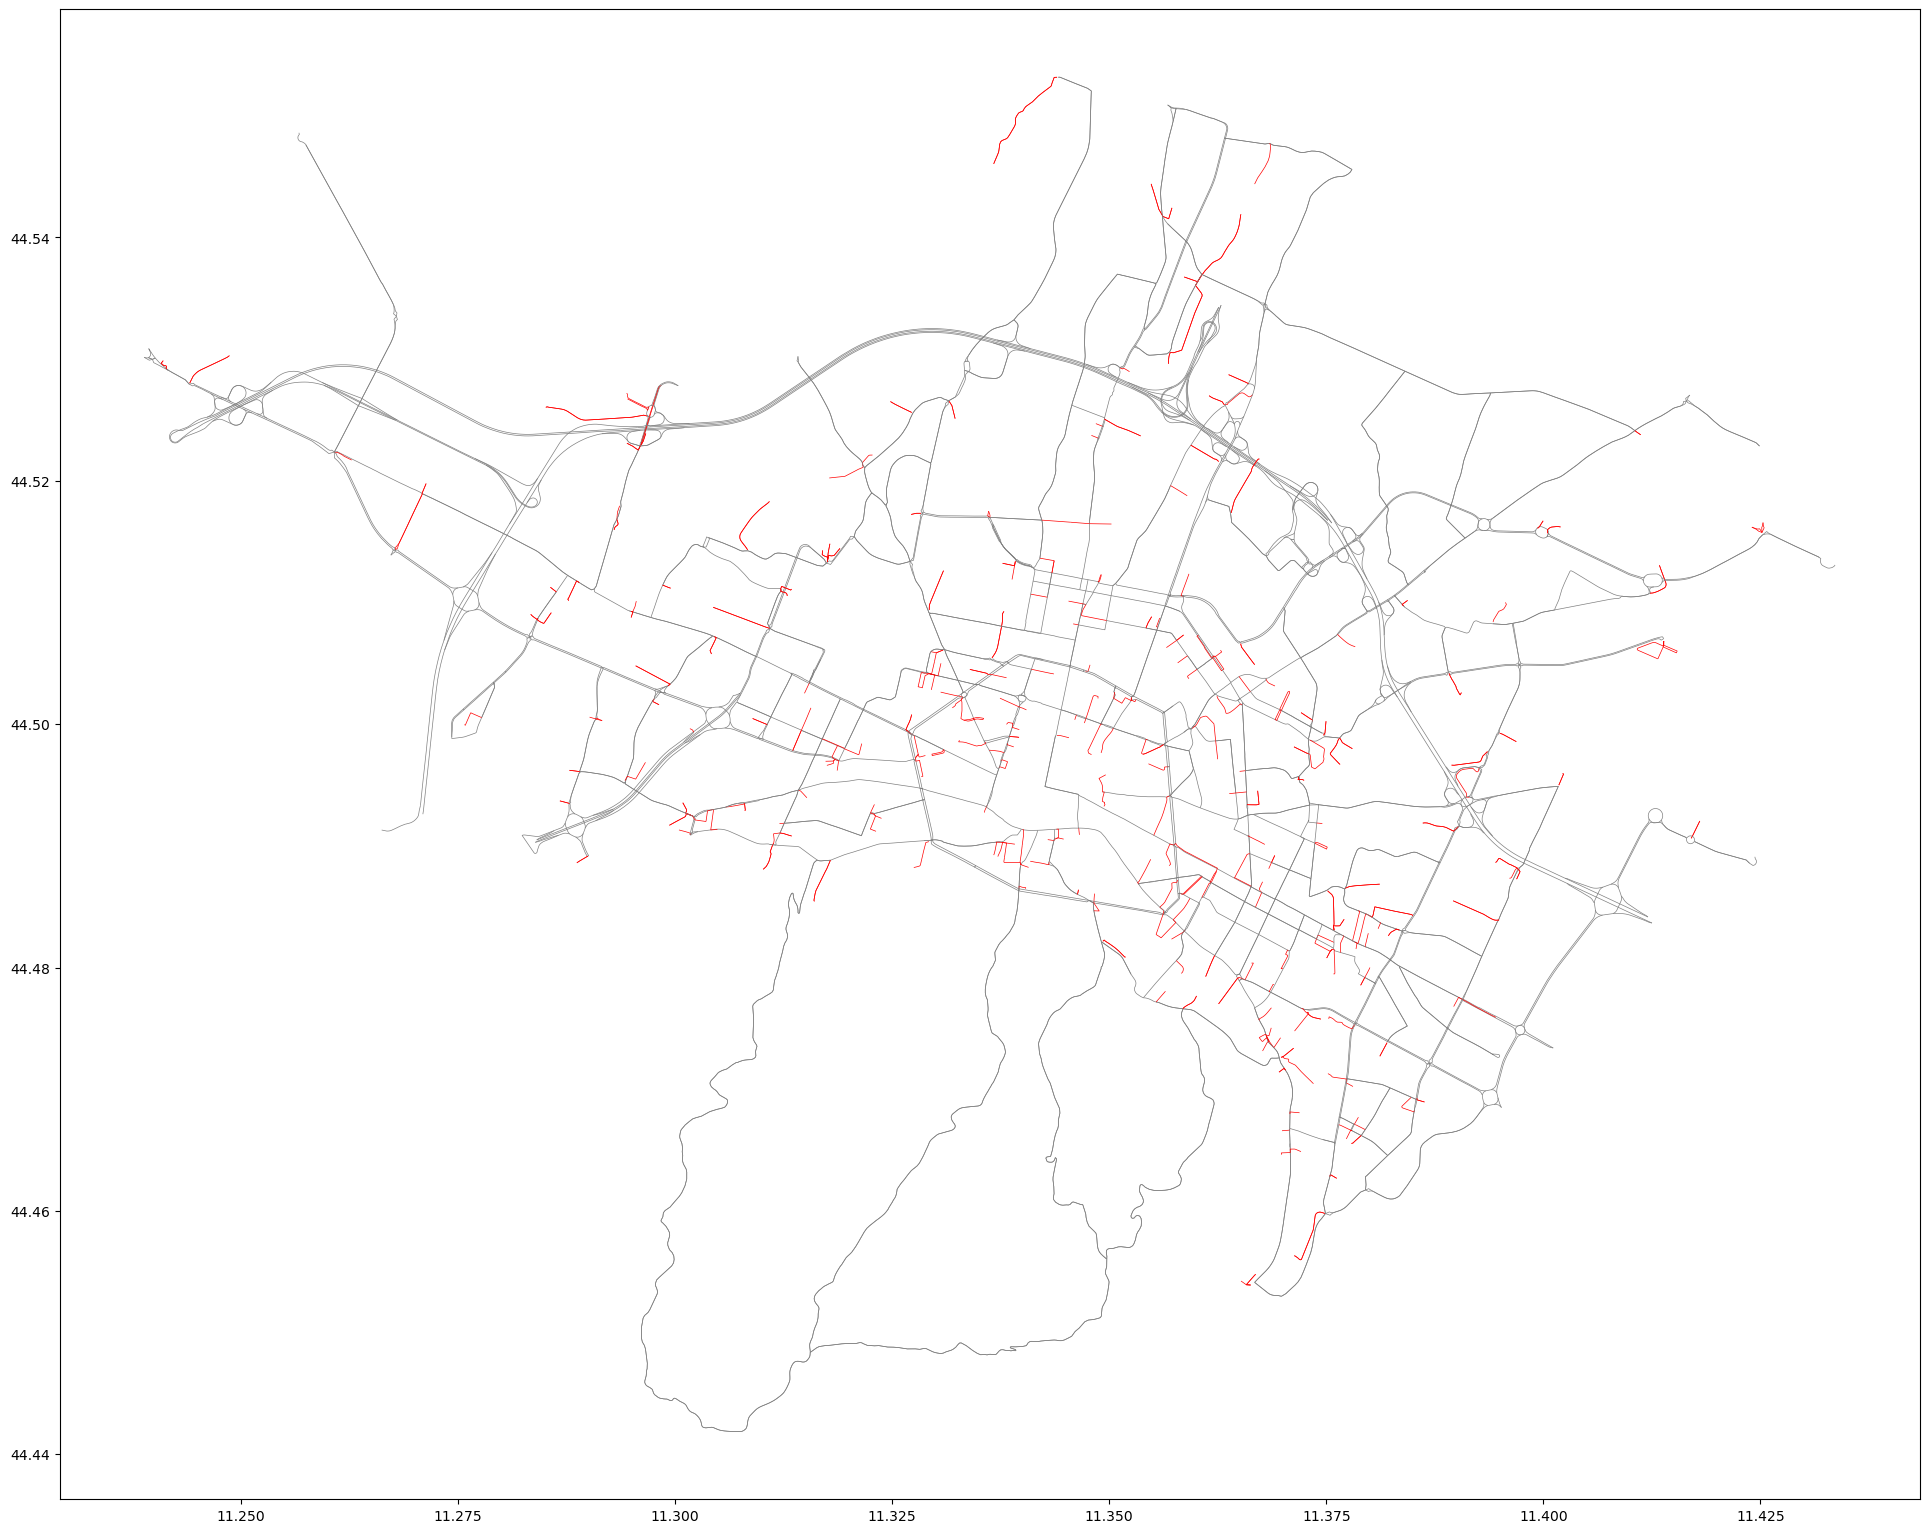

In [65]:
import matplotlib.pyplot as plt


# Extract edge data and color based on the "highway" attribute
edge_colors = []
for u, v, data in graph2.edges(data=True):
    if data.get("highway") in ['residential', 'living_street', 'unclassified', 'service', 'pedestrian', 'busway']:
        edge_colors.append("red")
    else:
        edge_colors.append("gray")

# Plot the graph with custom edge colors
fig, ax = ox.plot_graph(
    graph2,
    edge_color=edge_colors,
    node_size=1.5,  # Adjust node size as needed
    node_color="black",
    bgcolor="white",  # Background color
    edge_linewidth=0.5,  # Edge line width
    figsize=(24, 24),
    show=True,
    save=True  # Set to True if you want to save the plot
)
